In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

from lib.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchdrug import utils, data
from lib.disable_logger import DisableLogger

GPU = 1
device = f'cuda:{GPU}'
pipeline = Pipeline(
    model='lm-gearnet',
    dataset='atpbind3d',
    gpus=[GPU],
    model_kwargs={
        'gpu': GPU,
        'gearnet_hidden_dim_size': 512,
        'gearnet_hidden_dim_count': 4,
        'bert_freeze': False,
        'bert_freeze_layer_count': 29,
    },
    batch_size=16,
)


get dataset atpbind3d
Split num:  [337, 41, 41]
train samples: 337, valid samples: 41, test samples: 41


In [2]:
import pandas as pd
df = pd.DataFrame()

def create_pred_dataframe(pipeline, dataset, weights):
    weights_loaded = [
        torch.load(weight, map_location='cpu') for weight in weights
    ]
    df = pd.DataFrame()
    pipeline.task.eval()
    for protein_index, batch in enumerate(data.DataLoader(dataset, batch_size=1, shuffle=False)):
        batch = utils.cuda(batch, device=device)
        if protein_index % 10 == 9:
            print(f'processing protein {protein_index + 1} / {len(dataset)}')
        label = pipeline.task.target(batch)['label'].flatten()
        
        new_data = {
            'protein_index': protein_index,
            'residue_index': list(range(len(label))),
            'target': label.tolist(),
        }
        for i, weight in enumerate(weights_loaded):
            pipeline.task.load_state_dict(utils.cuda(weight, device=device) , strict=False)
            pred = pipeline.task.predict(batch).flatten()
            assert(len(label) == len(pred))
            new_data[f'pred_{i}'] = [round(t, 5) for t in pred.tolist()]
        new_data = pd.DataFrame(new_data)
        df = pd.concat([df, new_data])
    
    return df

In [80]:
weights = [
    'rus_5_0_0.6151.pth',
    'rus_5_1_0.6221.pth',
    'rus_5_2_0.6193.pth',
    'rus_5_3_0.6266.pth',
    'rus_5_4_0.6052.pth',
    'rus_5_5_0.6085.pth',
    'rus_5_6_0.5986.pth',
    'rus_5_7_0.6108.pth',
    'rus_5_8_0.6046.pth',
    'rus_5_9_0.6080.pth',
    'rus_10_0_0.59580.pth',
    'rus_10_1_0.59290.pth',
    'rus_10_2_0.6494.pth',
    'rus_10_3_0.6114.pth',
    'rus_10_4_0.59780.pth',
    'rus_10_5_0.6173.pth',
    'rus_10_6_0.6152.pth',
    'rus_10_7_0.6091.pth',
    'rus_10_8_0.5989.pth',
    'rus_10_9_0.5892.pth',
]

df_test = create_pred_dataframe(
    pipeline, 
    dataset=pipeline.test_set,
    weights=weights,
)

processing protein 10 / 41
processing protein 20 / 41
processing protein 30 / 41
processing protein 40 / 41


In [81]:
df_test

,protein_index,residue_index,target,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19
0,0,0,0,-16.58725,-14.26131,-16.12406,-17.27155,-17.83962,-10.77162,-13.69350,...,-4.92141,-7.67897,-20.22991,-20.48533,-21.74874,-18.47888,-6.23510,-10.18679,-14.27814,-18.09355
1,0,1,0,-11.96325,-21.95876,-15.71205,-11.19608,-11.87056,-13.52481,-11.52473,...,-11.46348,-14.48064,-11.28631,-16.70693,-18.76808,-16.06176,-10.71391,-9.14219,-11.86466,-15.89708
2,0,2,0,-12.12433,-20.94984,-14.40281,-15.84534,-17.09693,-12.92465,-15.36575,...,-15.60660,-17.53642,-10.43086,-13.11539,-13.56308,-15.95304,-14.32602,-5.63488,-9.34107,-16.48450
3,0,3,0,-19.78278,-16.06165,-12.00332,-18.59363,-26.20349,-13.50844,-17.26446,...,-19.59934,-16.11908,-12.52802,-19.19372,-20.83577,-19.28723,-16.08351,-8.92389,-18.32108,-15.50467
4,0,4,0,-19.56957,-21.85383,-15.06555,-29.07948,-25.97322,-18.14226,-16.69096,...,-22.19031,-23.51790,-15.44192,-24.09439,-22.55052,-17.46095,-15.89462,-13.15124,-19.76307,-19.25525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,40,345,0,-17.69944,-19.72926,-19.23244,-20.65278,-14.84283,-14.02413,-19.00901,...,-21.05940,-19.37619,-19.22956,-19.09377,-20.20825,-14.39639,-14.26981,-16.64324,-15.24863,-17.52347
346,40,346,0,-18.11542,-19.89686,-14.18944,-17.77581,-13.69436,-16.90982,-18.84981,...,-21.59207,-19.17856,-17.54622,-19.39499,-14.59765,-14.20519,-16.33788,-12.98285,-17.74381,-20.47103
347,40,347,0,-17.63147,-19.46121,-15.28850,-23.77349,-15.61055,-12.41029,-20.53154,...,-20.74844,-15.71322,-19.62271,-22.24987,-13.13520,-17.20610,-11.44981,-10.39922,-14.71510,-20.25729
348,40,348,0,-25.10613,-20.29464,-25.70001,-28.99287,-24.06890,-18.46996,-26.28154,...,-26.77276,-22.51775,-19.43706,-28.89057,-29.46522,-23.51024,-22.71839,-16.52744,-19.21923,-30.88894


In [83]:
df_test.query('target == 1 and pred_0 + pred_1 + pred_2 + pred_3 + pred_4 + pred_5 +pred_6 +pred_7 + pred_8 + pred_9 < 0')

,protein_index,residue_index,target,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19
169,0,169,1,-0.14417,0.68710,-0.72634,4.68817,-3.16660,0.54718,-1.64828,...,-0.92520,4.97815,-2.98688,0.26826,-9.29389,-0.77246,-0.30050,1.07183,2.48360,-2.36789
175,0,175,1,-4.37406,-2.37150,-6.37678,-5.85733,-7.95834,-4.59623,-2.20612,...,-8.56421,5.20776,-11.88360,-3.05506,-13.01669,-1.03432,-3.16449,-2.43444,-2.50788,0.16454
9,1,9,1,-0.09190,2.86914,-1.67035,-4.58974,0.67487,1.28991,-2.44845,...,-0.84966,0.40222,-4.85150,0.72357,-0.45765,-2.18314,-0.07710,-2.20832,-1.15199,-6.38764
12,1,12,1,-0.98649,-3.07326,-0.66944,-7.40173,-0.36445,-4.16329,-5.40117,...,-5.65155,-6.27916,-0.65469,-2.37811,-14.73051,-3.51716,-3.60641,-6.65819,-2.69598,-1.43212
195,1,195,1,-7.51313,-13.02179,-11.25883,-10.31025,-4.00688,-10.01748,-13.60678,...,-9.30306,-1.32837,-9.35328,-3.20131,-7.76162,-8.74919,-1.67521,-1.79049,-8.05183,-4.31013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,39,204,1,-2.31937,-3.60561,-7.00392,-9.62285,-6.75732,-7.75180,-4.96567,...,-2.01078,2.35760,-11.17265,-7.47727,-6.66340,-7.98270,-2.20709,-1.43151,-3.62402,-5.75066
211,39,211,1,0.87952,-2.39499,-3.13263,-2.30610,-1.71836,-5.09411,-5.07719,...,-1.40617,2.34303,1.90776,-4.92185,0.04039,-9.18252,0.23649,-1.34558,0.13036,-0.68826
69,40,69,1,0.32048,-0.57123,-3.47128,0.86771,-0.71187,-1.03418,-0.58739,...,2.03742,3.07241,-3.73548,-2.51004,-0.34339,2.56767,-3.39092,0.17945,0.02842,0.11446
196,40,196,1,-8.51411,-7.03684,-14.11259,-8.16317,-9.98089,-12.85957,-7.02843,...,-4.16712,0.38023,-10.06769,-9.90418,-5.96880,-5.85656,-2.96958,-0.28787,-7.96147,4.17067


In [91]:
df_valid = create_pred_dataframe(
    pipeline, 
    dataset=pipeline.valid_set,
    weights=weights,
)

processing protein 10 / 41
processing protein 20 / 41
processing protein 30 / 41
processing protein 40 / 41


In [96]:
df_train = create_pred_dataframe(
    pipeline, 
    dataset=pipeline.train_set,
    weights=weights,
)

processing protein 10 / 337
processing protein 20 / 337
processing protein 30 / 337
processing protein 40 / 337
processing protein 50 / 337
processing protein 60 / 337
processing protein 70 / 337


Create Dataset for learning:

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.X = torch.tensor(dataframe[['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9']].values, dtype=torch.float32)
        self.y = torch.tensor(dataframe['target'].values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
valid_dataset = CustomDataset(df_valid)
test_dataset = CustomDataset(df_test)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Mean Ensemble

In [88]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, matthews_corrcoef


def generate_mean_ensemble_metrics(df, threshold=0):
    sum_preds = df[list(filter(lambda a: a.startswith('pred_'), df.columns.tolist()))].sum(axis=1)
    final_prediction = (sum_preds > threshold).astype(int)

    # Sensitivity (Recall)
    sensitivity = recall_score(df['target'], final_prediction)

    # Specificity
    tn, fp, fn, tp = confusion_matrix(df['target'], final_prediction).ravel()
    specificity = tn / (tn + fp)

    # Accuracy
    accuracy = accuracy_score(df['target'], final_prediction)

    # Precision
    precision = precision_score(df['target'], final_prediction)
    mcc = matthews_corrcoef(df['target'], final_prediction)
    return {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "accuracy": accuracy,
        "precision": precision,
        "mcc": mcc,
    }

generate_mean_ensemble_metrics(df_test, threshold=-16.9)

{'sensitivity': 0.6012759170653907,
 'specificity': 0.9887620872898336,
 'accuracy': 0.968693209978523,
 'precision': 0.7450592885375494,
 'mcc': 0.6533735221404826}

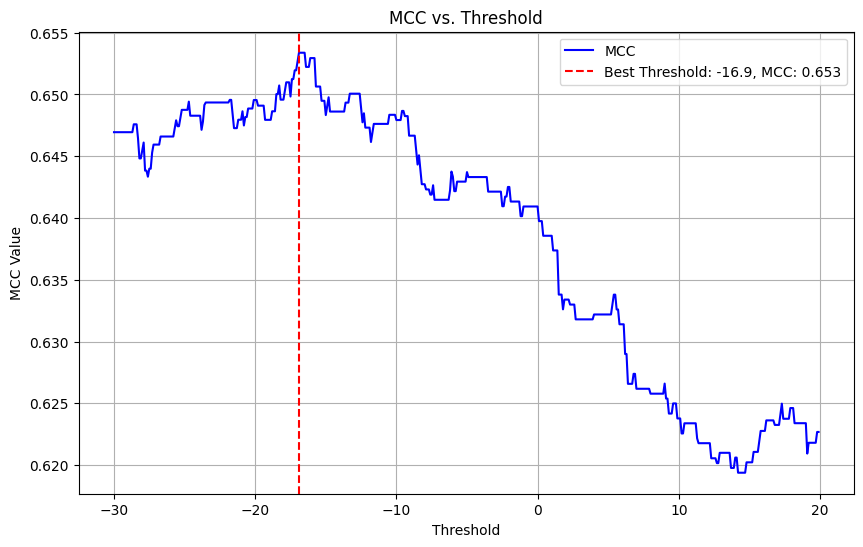

In [85]:
def draw_mean_ensemble_thrshold_chart(df, start=0, end=30):
    # Create a list of thresholds to test
    thresholds = np.arange(start, end, 0.1)  # Adjust the step size as necessary
    mcc_values = []

    # Loop through thresholds and compute MCC
    for threshold in thresholds:
        metrics = generate_mean_ensemble_metrics(df, threshold)
        mcc_values.append(metrics['mcc'])

    # Identify threshold with the best MCC
    best_threshold = thresholds[np.argmax(mcc_values)]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, mcc_values, label='MCC', color='blue')
    plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.1f}, MCC: {max(mcc_values):.3f}')
    plt.xlabel('Threshold')
    plt.ylabel('MCC Value')
    plt.title('MCC vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

draw_mean_ensemble_thrshold_chart(df_test, start=-30, end=20)

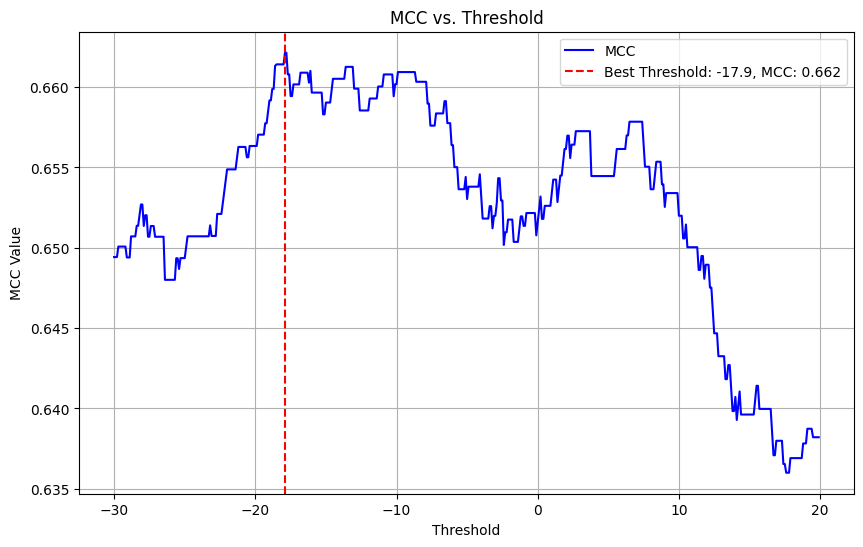

In [92]:
draw_mean_ensemble_thrshold_chart(df_valid, start=-30, end=20)

In [95]:
df_train

,protein_index,residue_index,target,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
0,0,0,0,-3.34078,-3.99171,-5.53482,-4.89031,-3.17529,-4.91712,-4.04500,-3.38465,-4.12005,-4.73727
1,0,1,0,-2.04767,-3.06922,-2.41807,-3.11660,-1.26233,-3.47615,-2.80255,-2.16291,-2.78471,-2.76917
2,0,2,0,-2.73427,-2.97316,-2.21603,-3.11366,-1.57289,-3.16864,-3.30050,-2.18193,-3.12061,-2.59389
3,0,3,0,-3.55501,-3.21512,-2.94564,-4.24775,-2.14212,-4.48979,-3.12445,-2.89117,-3.03285,-3.19782
4,0,4,0,-4.46869,-4.36819,-3.10835,-4.97666,-3.12118,-5.59486,-3.87978,-3.53662,-3.76473,-3.69526
...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,336,308,0,-4.09667,-3.83282,-3.68114,-5.22876,-3.48648,-4.76675,-4.39744,-3.26858,-3.97536,-3.79661
309,336,309,0,-3.93079,-4.15758,-4.30619,-5.12658,-3.74109,-4.64210,-4.99793,-3.56649,-4.78624,-4.18969
310,336,310,0,-3.42721,-3.25288,-3.00180,-4.65020,-2.86910,-4.45202,-4.07935,-2.85041,-3.67599,-3.64139
311,336,311,0,-3.47742,-3.51381,-2.99272,-4.85414,-2.52000,-4.30644,-3.96227,-3.10526,-3.29450,-3.54800


# MLP

In [93]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()

input_size = 10
hidden_size = 32
output_size = 1

model = MLP(input_size, hidden_size, output_size)

learning_rate = 0.0001
num_epochs = 10

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    model.train()
    sum_loss = 0.0
    for inputs, targets in valid_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        sum_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, sum_loss))


model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions = (outputs > 0.5).float()
        all_preds.extend(predictions.numpy())
        all_targets.extend(targets.numpy())

mcc = matthews_corrcoef(all_targets, all_preds)
print('Matthews Correlation Coefficient on Test Set:', mcc)


NameError: name 'valid_loader' is not defined

# XGBoost

In [176]:
import xgboost as xgb



X_valid = df_valid[['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9']]
y_valid = df_valid['target']

X_test = df_test[['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9']]
y_test = df_test['target']

def create_xgb_classifier():
    return xgb.XGBClassifier(
        booster='gbtree',
        learning_rate=0.1,
        gamma=0.1,
        max_depth=10,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        colsample_bylevel=0.8,
        colsample_bynode=0.8,
        reg_lambda=1,
        reg_alpha=0,
        scale_pos_weight=1,
        n_estimators=500,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
    )
clf = create_xgb_classifier()
clf.fit(X_valid, y_valid)

y_pred = clf.predict(X_test)
mcc = matthews_corrcoef(y_test, y_pred)

print('Matthews Correlation Coefficient on Test Set:', mcc)

# How about applying sigmoid:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
X_valid_sigmoid = X_valid.applymap(sigmoid)
X_test_sigmoid = X_test.applymap(sigmoid)

clf = create_xgb_classifier()
clf.fit(X_valid_sigmoid, y_valid)
y_pred = clf.predict(X_test_sigmoid)
mcc = matthews_corrcoef(y_test, y_pred)

print('Matthews Correlation Coefficient on Test Set:', mcc)


/home/jaechanlee/miniconda3/envs/jc/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Matthews Correlation Coefficient on Test Set: 0.5868540518431951


/home/jaechanlee/miniconda3/envs/jc/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Matthews Correlation Coefficient on Test Set: 0.6021520755539236


# Linear Regression

In [212]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(solver='lbfgs', max_iter=100)
model.fit(X_valid, y_valid)
coefficients = model.coef_[0]
y_pred_probabilities = model.predict_proba(X_test)[:,1]
y_pred = (y_pred_probabilities > 0.5).astype(int)
mcc = matthews_corrcoef(y_test, y_pred)
print('Matthews Correlation Coefficient:', mcc)


model.coef_[0] = np.array([1] * 10)
y_pred_probabilities = model.predict_proba(X_test)[:,1]
y_pred = (y_pred_probabilities > 0.5).astype(int)
mcc = matthews_corrcoef(y_test, y_pred)
print('Assuming linear regression of coefficient all 1, then Matthews Correlation Coefficient:', mcc)


Matthews Correlation Coefficient: 0.6187099439127742
Assuming linear regression of coefficient all 1, then Matthews Correlation Coefficient: 0.6293961454339936


In [77]:

bce_weights = [
    'rus_5_10_bce_0.0289.pth',
    'rus_5_11_bce_0.0286.pth',
    'rus_5_12_bce_0.0267.pth',
    'rus_5_13_bce_0.0300.pth',
    'rus_5_14_bce_0.0268.pth',
    'rus_5_15_bce_0.0341.pth',
    'rus_5_16_bce_0.0273.pth',
    'rus_5_17_bce_0.0266.pth',
    'rus_5_18_bce_0.0302.pth',
    'rus_5_19_bce_0.0304.pth', 
]

df_bce_test = create_pred_dataframe(
    pipeline, 
    dataset=pipeline.test_set,
    weights=bce_weights,
)

processing protein 10 / 41
processing protein 20 / 41
processing protein 30 / 41
processing protein 40 / 41


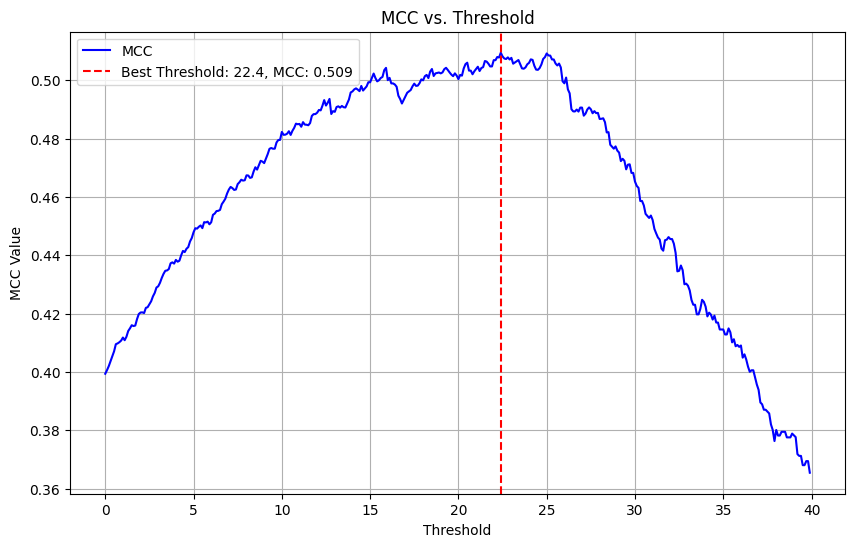

In [79]:
draw_mean_ensemble_thrshold_chart(df_bce_test, start=0, end=40)